## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import make_interp_spline, BSpline

## Get Data

In [2]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())
with open('./data/processed/codes_to_carrier_dict.txt', 'rb') as handle:
    codes_to_carrier = pickle.loads(handle.read())
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


### Overview

In [3]:
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('a weekly total of %i arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21953 domestic flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21953 flights result in
a weekly total of 43906 arrivals and departures.


### Operator Marketshares

In [4]:
def plt_shr(df, feature):
    
    '''
    
    For the given feature, plots by operator:
        the feature value distribution, and 
        the market share by the feature.
    
    '''
    
    mkt_shr_df = pd.DataFrame(data = None, index = codes_to_carrier.keys(), columns = [feature, 'mkt_share'])
    
    for operator in operators:
        op_flights = df.query('operator == @operator')[feature].sum()
        mkt_shr_df.loc[mkt_shr_df.index == operator, feature] = op_flights
        mkt_shr_df.loc[mkt_shr_df.index == operator, 'mkt_share'] = round(op_flights/n_flights, 4)

    # Combining AI and AAS
    mkt_shr_df.at['AI'] = mkt_shr_df[(mkt_shr_df.index == 'AI') | (mkt_shr_df.index == 'AAS')].sum(axis = 0) 
    mkt_shr_df = mkt_shr_df.drop(index = 'AAS')  
    mkt_shr_df = mkt_shr_df.sort_values(by = feature, ascending = False)
    
    plt.figure(figsize = (15, 6))

    plt.subplot(1, 2, 1)
    plt.bar(mkt_shr_df.index, mkt_shr_df.iloc[:, 0])
    plt.title('%s by Operator' % mkt_shr_df.columns[0], 
              fontdict = {'fontsize' : 14, 'fontweight' : 'bold'})

    plt.subplot(1, 2, 2)
    plt.pie(mkt_shr_df.iloc[:, 1], radius = 1, autopct = '%1.1f%%', 
            labels = [codes_to_carrier[value] for value in mkt_shr_df.index])
    plt.title('%s Operator Marketshare' % mkt_shr_df.columns[0], 
              fontdict = {'fontsize' : 14, 'fontweight' : 'bold'})

    plt.show()
    
    return
    

#### Weekly Flights Marketshare

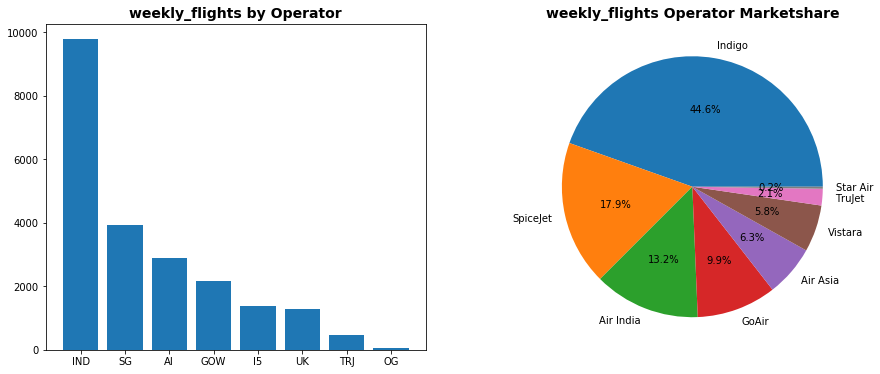

In [5]:
plt_shr(dat, 'weekly_flights')

#### Weekly Capacity Marketshare

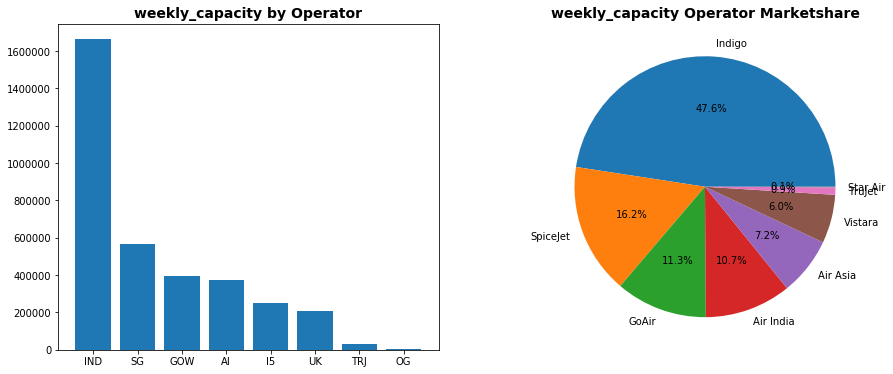

In [6]:
plt_shr(dat, 'weekly_capacity')

#### Weekly Estimated Passengers Marketshare

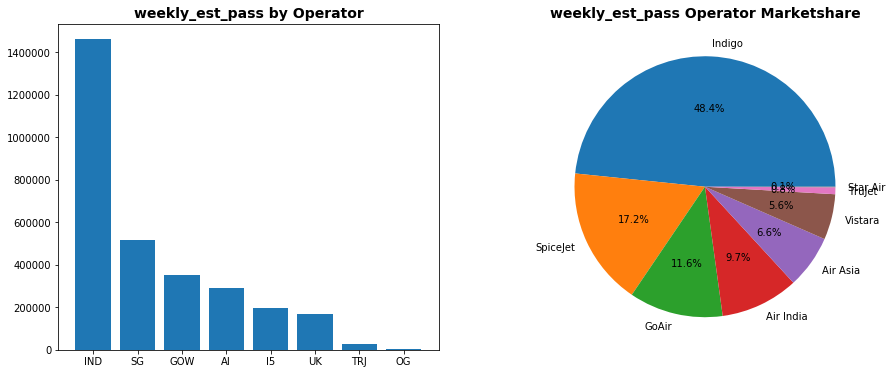

In [7]:
plt_shr(dat, 'weekly_est_pass')

<ul>
    <li>Indigo is clearly the 800 pound gorrila of the Indian domestic aviation sector flying almost 50% of all capacity and all passengers.
    <li>SpiceJet is a distant 2nd.
    <li>GoAir flies lesser number of flights than AirIndia, but beats out the state owned operator, flying higher capacity and higher number of passengers.
</ul>

### Operator and Cities

#### Operator City Reach

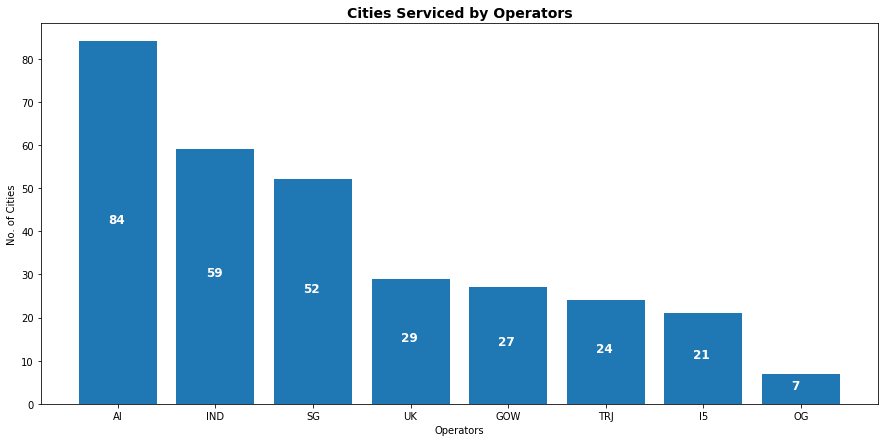

In [8]:
# Combining AI and AAS and counting distinct cities flown by these two operators
AI_cities = dat.query('operator == "AI"').groupby(by = 'from').count().index.tolist()
AAS_cities = dat.query('operator == "AAS"').groupby(by = 'from').count().index.tolist()
AI_cities = list(set(AI_cities + AAS_cities))

df = pd.DataFrame(data = None, index = codes_to_carrier.keys(), columns = ['Cities Reached'])

for operator in operators:
    if operator == 'AI' or operator == 'AAS':
        continue
    else:
        foo = len(dat.query('operator == @operator').groupby(by = 'from').count().index)
        df.loc[df.index == operator, 'Cities Reached'] = foo

df.at['AI'] = len(AI_cities)
df = df.drop(index = 'AAS')  
df = df.sort_values(by = 'Cities Reached', ascending = False)

plt.figure(figsize = (15, 7))
x = np.arange(len(df.index))
plt.bar(x, df['Cities Reached'])
plt.title('Cities Serviced by Operators', fontdict = {'fontsize' : 14, 'fontweight' : 'bold'})
plt.xlabel('Operators')
plt.ylabel('No. of Cities')
plt.xticks(x, labels = df.index)
for i, v in enumerate(df['Cities Reached']):
    plt.text(i- .1, v/2, str(v), color = 'white', fontdict = {'fontsize' : 12, 'fontweight' : 'bold'})

plt.show()

#### Operator Marketshare in Top Cities

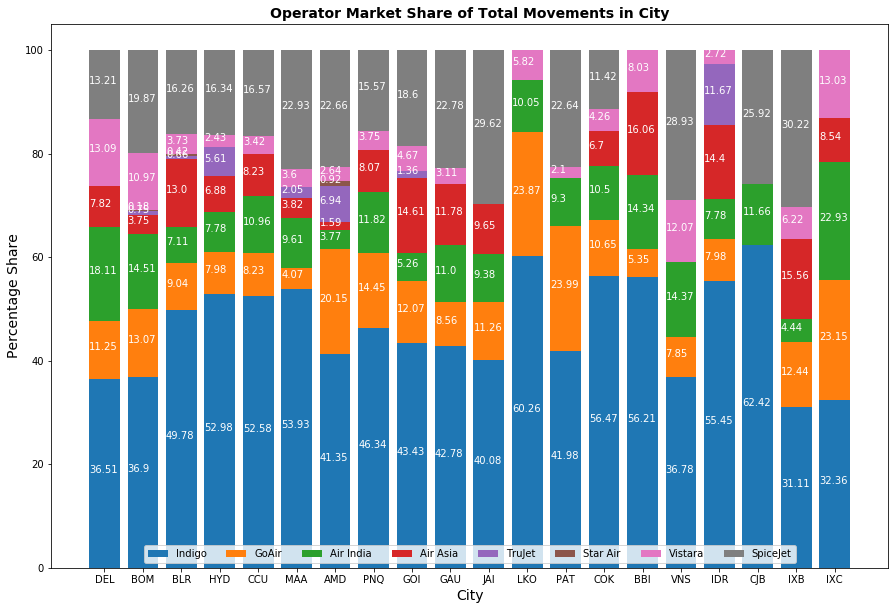

In [9]:
top_cities = ['DEL', 'BOM', 'BLR', 'HYD', 'CCU', 'MAA', 'AMD', 'PNQ', 'GOI', 'GAU', 'JAI', 'LKO', 'PAT', 
              'COK', 'BBI', 'VNS', 'IDR', 'CJB', 'IXB', 'IXC']

df_city_share = pd.DataFrame(data = None, index = codes_to_carrier.keys(), columns = top_cities)

for city in top_cities:
    df = pd.DataFrame(data = None, index = codes_to_carrier.keys(), columns = ['weekly_flights', 'mkt_share'])
    n_city_flights = dat.query('`from` == @city | to == @city')['weekly_flights'].sum()
    for operator in operators:
        op_flights = dat.query('(operator == @operator) & (`from` == @city | to == @city)')['weekly_flights'].sum()
        df.loc[df.index == operator, 'weekly_flights'] = op_flights
        df.loc[df.index == operator, 'mkt_share'] = round(op_flights/n_city_flights, 4)
    
    df_city_share[city] = df['mkt_share']

df_city_share.at['AI'] = df_city_share[(df_city_share.index == 'AI') | 
                                       (df_city_share.index == 'AAS')].sum(axis = 0) # Combining AI and AAS
df_city_share = df_city_share.drop(index = 'AAS')

plt.figure(figsize = (15, 10))
n_col = 3
n_row = np.ceil(len(top_cities)/n_col)

y_offset = np.zeros(len(df_city_share.columns))

for operator in df_city_share.index:
    y = np.array(df_city_share.iloc[df_city_share.index == operator, :])[0]*100
    plt.bar(df_city_share.columns, y, label = codes_to_carrier[operator], bottom = y_offset)
    for i, v in enumerate(y):
        if v == 0: v_lab = ''           #if v == 0, then suppress it from being shown on the graph
        else: v_lab = str(round(v, 2))
        plt.text(i - 0.4, y_offset[i] + v/2, v_lab, color = 'white')
    
    y_offset = y_offset + y
        
plt.ylabel('Percentage Share', fontdict = {'fontsize': 14})
plt.xlabel('City', fontdict = {'fontsize': 14})
plt.title('Operator Market Share of Total Movements in City',
          fontdict = {'fontsize': 14, 'fontweight' : 'bold'})
plt.legend(loc = 'lower center', ncol = len(df_city_share.index))
plt.show()
    

#### Observations
<ul>
    <li>Both Indigo and AirIndia service all of the top 20 cities.
    <li>Both GoAir and SpiceJet service 19 of the top 20 cities.
    <li>Vistara services 18 of the top 20 cities while AirAsia services 16.

#### Operators' Top Cities

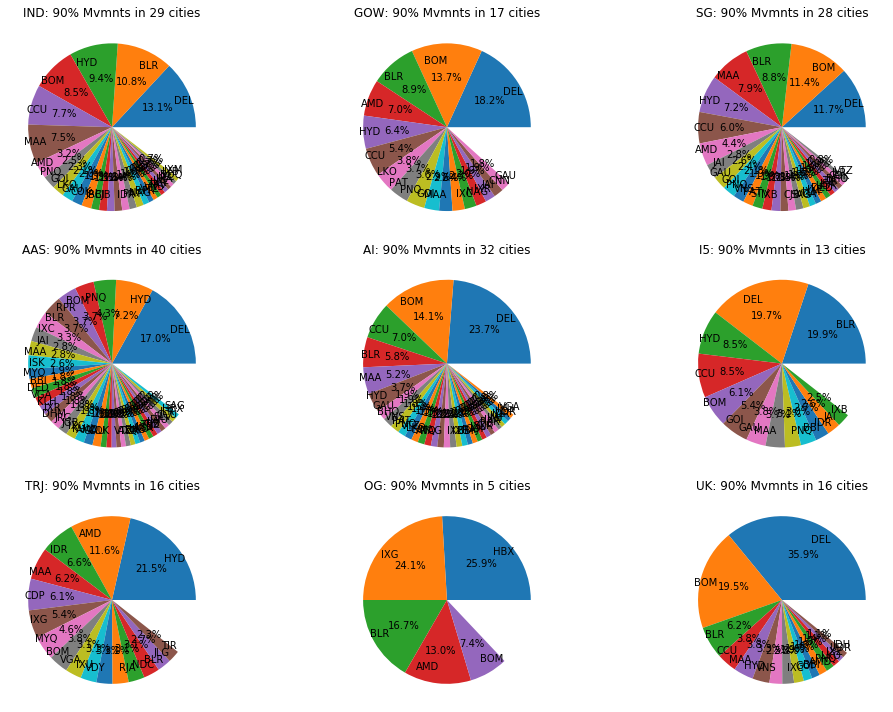

In [10]:
plt.figure(figsize = (15, 10))
n_col = 3
n_row = np.ceil(n_operators/n_col)
i = 1
threshold = 0.90

for operator in operators:
    df = pd.DataFrame(data = None, index = codes_to_city.keys(), columns = ['weekly_mvmnts', 'share'])
    n_opr_mvmnts = dat.query('operator == @operator')['weekly_flights'].sum()*2
    for city in codes_to_city.keys():
        cty_mvmnts = dat.query('(operator == @operator) & (`from` == @city | to == @city)')['weekly_flights'].sum()
        df.loc[df.index == city, 'weekly_mvmnts'] = cty_mvmnts
        df.loc[df.index == city, 'share'] = cty_mvmnts/n_opr_mvmnts
        
    df = df.sort_values(by = 'share', ascending = False)
    df['cum_sum'] = df.share.cumsum()
    indx = df[df.cum_sum <= threshold].index.tolist()
    df = df[df.index.isin(indx)]
    
    plt.subplot(n_row, n_col, i)
    plt.pie(df.share, radius = 1, autopct = '%1.1f%%', labeldistance = 0.8, 
            labels = [value for value in df.index])
    plt.title('%s: %i%% Mvmnts in %i cities' % (operator, threshold*100, len(indx)), 
              fontdict = {'fontsize' : 12})
    i += 1

plt.tight_layout()
plt.show()
    

#### Observations
<ul>
    <li>When compared to Indio or SpiceJet or AirIndia, GoAir flies a significantly smaller number of cities.
    <li>GoAir's strategy of maintaining a as-small-as-possible footprint becomes even more apparent when the number of cities it flies is compared to the numbber of cities much smaller players like Vistara and TruJet fly to.
</ul>

### Operator Movements and Time Distributions

#### Day-of-Week Distribution

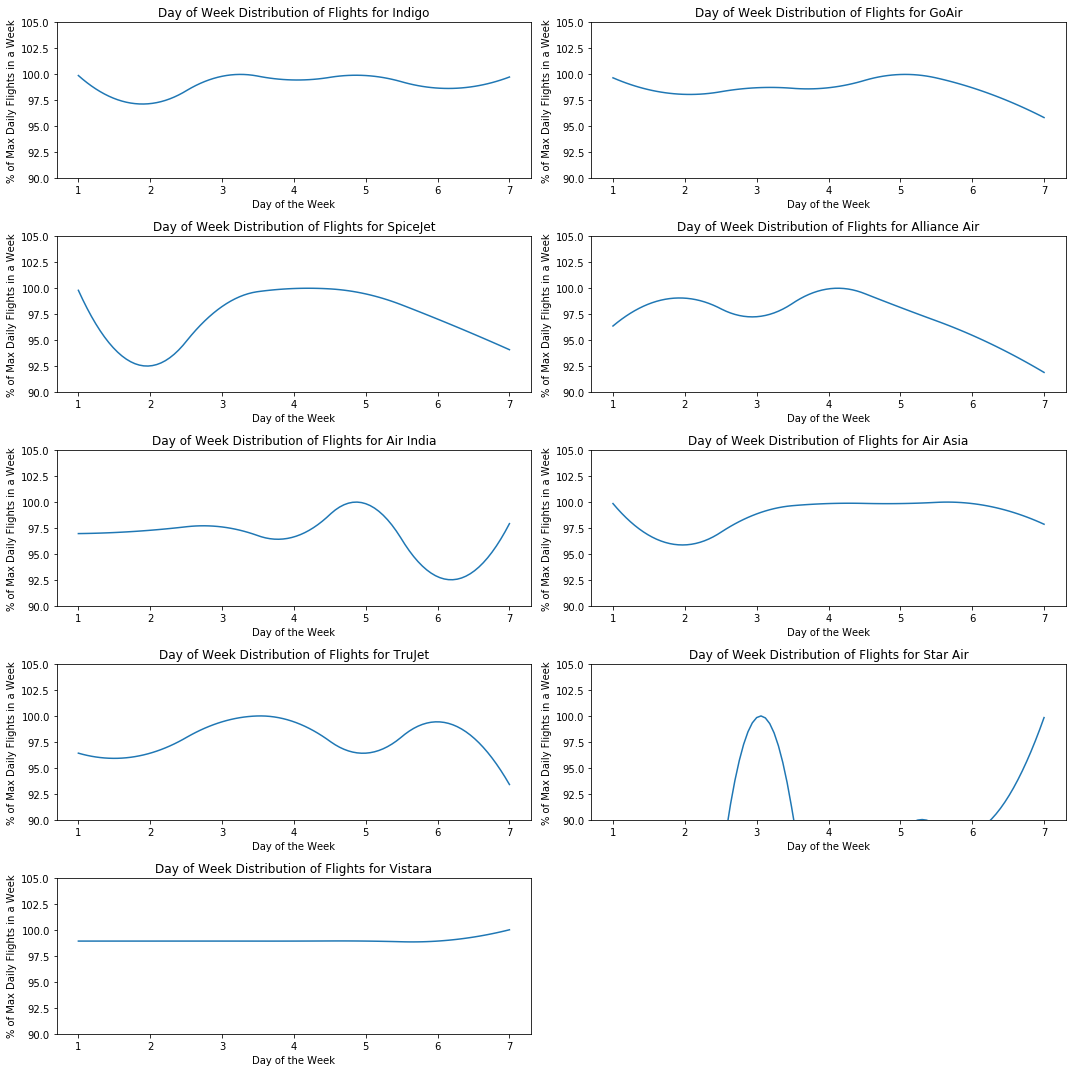

In [126]:
# Setting up the plot parameters
n_col = 2
n_row = np.ceil(len(operators)/n_col)
spline_pts = 100
smoothing_param = 2
subplt = 1
x_orig = np.arange(1, 8 ,1)
x_augm = np.linspace(1, 7, spline_pts)

plt.figure(figsize = (15, 15))

for operator in operators:
    
    '''Get Daily Flights for the operator.'''
    
    mvmnts = []
    for i in range(1, 8, 1):
        day = 'day_' + str(i)
        try:
            foo = dat.query('operator == @operator').groupby([day])['flight'].count()[1]
        except KeyError:
            foo = 0
        
        mvmnts.append(foo)
        
    '''Plot the day of the week distribution'''
    
    plt.subplot(n_row, n_col, subplt)
    spline = make_interp_spline(x_orig, mvmnts, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))       # prevent y from taking a negative value
    y_axis = (y_axis/np.max(y_axis))*100
    plt.plot(x_augm, y_axis)
    plt.xlabel('Day of the Week')
    plt.ylabel('% of Max Daily Flights in a Week')
    plt.ylim((90, 105))
    plt.title('Day of Week Distribution of Flights for %s' % codes_to_carrier[operator])
    subplt += 1
    
plt.tight_layout()
plt.show()

#### Observations
<ul>
    <li>Most operators fly about the same number of flights all days of the week; the plot for Vistara is practically a straight line.
    <li>Of all the large operators, GoAir on Sunday and SpiceJet on Tuesday and Sunday, reduce daily flights by as much as 5% as compared the rest of the days of week.

#### Operators' Time-of-Day Distribution

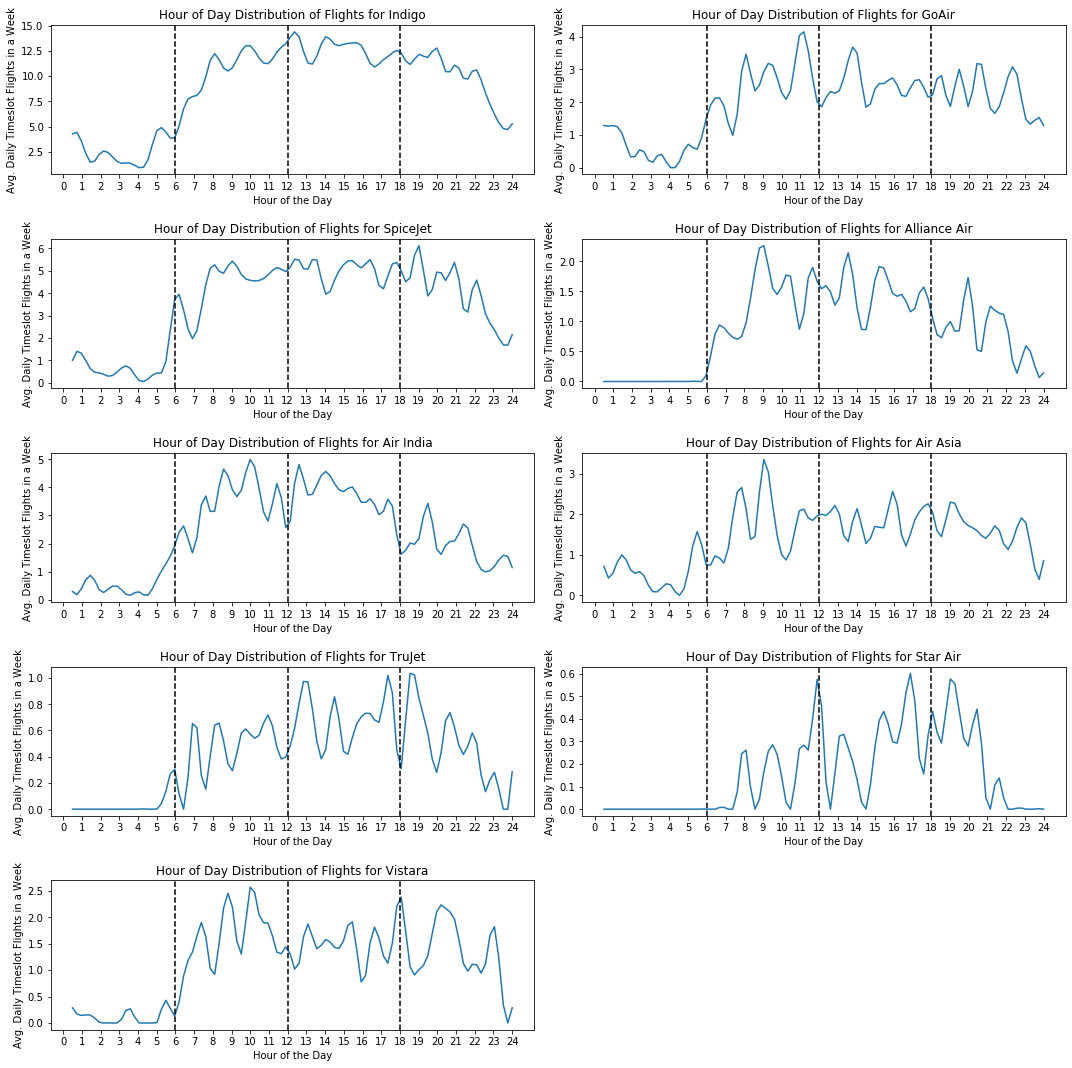

In [123]:
# Setting up the plot parameters
n_col = 2
n_row = np.ceil(len(operators)/n_col)
spline_pts = 100
smoothing_param = 3
subplt = 1
x_orig = np.arange(1, 49 ,1)
x_augm = np.linspace(1, 48, spline_pts)

plt.figure(figsize = (15, 15))

for operator in operators:
    
    '''Get Timeslot-wise Inward and Outward Flights for the operator. '''
    
    mvmnts_in = []
    mvmnts_out = []
    for i in range(1, 49, 1):
        try:
            foo = dat.query('operator == @operator').groupby(['to_time_slot'])['flight'].count()[i]
        except KeyError:
            foo = 0
        mvmnts_in.append(foo)
        try:
            foo = dat.query('operator == @operator').groupby(['from_time_slot'])['flight'].count()[i]
        except KeyError:
            foo = 0
        mvmnts_out.append(foo)
        
    mvmnts = [sum(x) for x in zip(mvmnts_in, mvmnts_out)]
    '''Plot the Timeslot-wise Inward and Outward Flighs for the Operator'''
    
    plt.subplot(n_row, n_col, subplt)
    spline = make_interp_spline(x_orig, mvmnts, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))/7       # prevent y from taking a negative value
    plt.plot(x_augm, y_axis)
    
    plt.axvline(x = 12, color = 'black', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'black', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'black', linestyle = '--')         # 6 p.m.
    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1))  # to get 24 hours on the x-axis
    plt.xlabel('Hour of the Day')
    plt.ylabel('Avg. Daily Timeslot Flights in a Week')
    plt.title('Hour of Day Distribution of Flights for %s' % codes_to_carrier[operator])
    subplt += 1
    
plt.tight_layout()
plt.show()
